### 정리한 데이터로 노아 모델 돌려보기

1. 데이터 로드

In [3]:
import pandas as pd

file = '../../DATA/SMP_201004_202403.csv'
df = pd.read_csv(file, encoding='utf-8')
df.head()

,날짜,통합
0,2001-04-01,50.705398
1,2001-05-01,52.552364
2,2001-06-01,51.247385
3,2001-07-01,47.428339
4,2001-08-01,42.293200


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   날짜      276 non-null    object 
 1   통합      276 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.4+ KB


In [8]:
means = df['통합'].mean()
stds = df['통합'].std()
print(means, stds)

def denorms(x):
    return x * 43.89968 + 101.88185

101.88185278345824 43.89968221156307


In [6]:
# 날짜 데이터를 datetime 형식으로 변환
df['날짜'] = pd.to_datetime(df['날짜'])
df.info()

# 통합 열 정규화
def normalize(x):
    return (x - x.mean()) / x.std()

def denormalize(x, mean, std):
    return x * std + mean

df['norm'] = normalize(df['통합'])
df['denorm'] = denormalize(df['norm'], df['통합'].mean(), df['통합'].std())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   날짜      276 non-null    datetime64[ns]
 1   통합      276 non-null    float64       
 2   norm    276 non-null    float64       
 3   denorm  276 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 8.8 KB


,날짜,통합,norm,denorm
0,2001-04-01,50.705398,-1.165759,50.705398
1,2001-05-01,52.552364,-1.123687,52.552364
2,2001-06-01,51.247385,-1.153413,51.247385
3,2001-07-01,47.428339,-1.240408,47.428339
4,2001-08-01,42.293200,-1.357382,42.293200


normalize, denormalize 함수 잘 돌아간다

In [7]:
# csv 파일로 저장
df.to_csv('../../DATA/SMP_201004_202403_norm.csv', index=False, encoding='utf-8')

2. 이제 std 열을 모델 학습

In [4]:
import torch

# dataset 생성
class SMPDataset:
    def __init__(self, df, seq_len=12):
        data = df['norm'].values
        self.data = torch.FloatTensor(data)
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        X = self.data[idx:idx+self.seq_len]
        y = self.data[idx+self.seq_len]
        return X, y

# Check
smp_data = SMPDataset(df, seq_len=6)
print(len(smp_data))
for i in range(5):
    print(smp_data[i])
    break

270
(tensor([-1.1658, -1.1237, -1.1534, -1.2404, -1.3574, -1.3062]), tensor(-1.2517))


In [5]:
# DataLoader 생성
from torch.utils.data import DataLoader

smp_loader = DataLoader(smp_data, batch_size=8, shuffle=False)
for X, y in smp_loader:
    print(X)
    print(y)
    break

tensor([[-1.1658, -1.1237, -1.1534, -1.2404, -1.3574, -1.3062],
        [-1.1237, -1.1534, -1.2404, -1.3574, -1.3062, -1.2517],
        [-1.1534, -1.2404, -1.3574, -1.3062, -1.2517, -1.2470],
        [-1.2404, -1.3574, -1.3062, -1.2517, -1.2470, -1.0387],
        [-1.3574, -1.3062, -1.2517, -1.2470, -1.0387, -0.9969],
        [-1.3062, -1.2517, -1.2470, -1.0387, -0.9969, -1.1334],
        [-1.2517, -1.2470, -1.0387, -0.9969, -1.1334, -1.1704],
        [-1.2470, -1.0387, -0.9969, -1.1334, -1.1704, -1.2558]])
tensor([-1.2517, -1.2470, -1.0387, -0.9969, -1.1334, -1.1704, -1.2558, -1.2220])


데이터로더도 순서대로 잘 나오는 걸 확인

3. 모델 학습

In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import r2_score

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size=6, hidden_size=30, num_layers=2, batch_first=True)
        self.fc = nn.Linear(30, 1)

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x[:, -1])
        return x

model = RNN()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

def compute_r2_score(y_true, y_pred):
    return r2_score(y_true.detach().cpu().numpy(), y_pred.detach().cpu().numpy())

for epoch in range(20000):
    for i, (x, y) in enumerate(smp_loader):
        optimizer.zero_grad()
        output = model(x.unsqueeze(1).float())
        loss = criterion(output.squeeze(), y.float())
        loss.backward()
        optimizer.step()

    if epoch % 1000 == 0:
        y_true = y.float().unsqueeze(1)  
        y_pred = model(x.unsqueeze(1).float())  
        r2 = compute_r2_score(y_true, y_pred.squeeze())

        print(f"Epoch {epoch}: Loss: {loss}, R-squared: {r2}")

In [17]:
# 모델 저장
# torch.save(model.state_dict(), 'rnn_model.pth')

In [7]:
# 모델 불러오기
model = RNN()
model.load_state_dict(torch.load('rnn_model.pth'))

<All keys matched successfully>

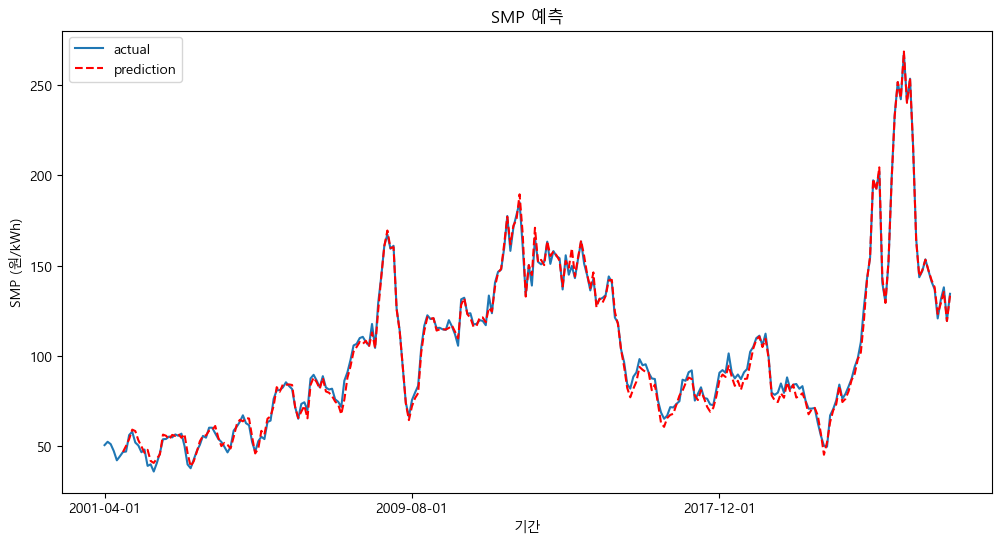

In [15]:
# 예측
# - 데이터 전체를 예측하고 그 값을 시각화하기
import matplotlib.pyplot as plt

preds = []
for X, y in smp_loader:
    y_pred = model(X.unsqueeze(1).float())
    # print(y_pred)
    preds.append(y_pred)

preds = torch.cat(preds)
preds = preds.detach().numpy()

plt.figure(figsize=(12, 6))
# 한글 인코딩
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.plot(df['통합'].values, label='actual')
plt.plot(range(6, len(df)), denormalize(preds, df['통합'].mean(), df['통합'].std()), label='prediction', linestyle='--', color='red')
plt.xlabel('기간')
plt.xticks(range(0, len(df), 100), df['날짜'].dt.strftime('%Y-%m-%d').values[::100])
plt.ylabel('SMP (원/kWh)')
plt.title('SMP 예측')
plt.legend()
plt.show()